# Answerability Classification

IMPORTANT NOTE: this notebook has the purpose to show that the training of `distilbert-base-cased` on answerability classification took place. To all the explaination on how the dataset is prepared, preprocessed and how the model is trained please refer to the `Anserability Classification` notebook where everything is explained in detail and a comparison between all different trained models is shown.

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 6.7 MB/s eta 0:00:00


In [2]:
import random
import json
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DefaultDataCollator
from transformers import TrainingArguments
from transformers import Trainer
from torch.utils.data import DataLoader
from transformers import default_data_collator
from accelerate import Accelerator
from transformers import BertForQuestionAnswering
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_scheduler

In [4]:
import os
from google.colab import drive

# Mount the Google drive storage
drive.mount('/content/drive')

# Move to the directory with the notebooks and the data set
# (note, you may need to change this path according to your directory structure)
os.chdir('/content/drive/MyDrive/NLP_project/dataset/')

# Check the currect working directory
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/NLP_project/dataset'

## Loading of the dataset SQuAD 2.0

In [5]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']

train_json = load_data('train-v2.0.json')
validation_json = load_data('dev-v2.0.json')

In [6]:
def extract_data_from_json(data):
    dataset = []

    for article in data:
        for paragraph in article['paragraphs']:
            for qas in paragraph['qas']:
                if qas['is_impossible'] == False: 
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : [qas['answers'][0]['text']], 'answer_start': [int(qas['answers'][0]['answer_start'])]},
                                    'is_possible': True
                    })
                else:
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : [''], 'answer_start': [0]},
                                    'is_possible': False
                    })

    return dataset

train_data = extract_data_from_json(train_json)
dev_data = extract_data_from_json(validation_json)

#train_data = random.sample(train_data, int(len(train_data) * 0.2))

In [7]:
raw_datasets = DatasetDict()
raw_datasets['train'] = Dataset.from_list(train_data)
raw_datasets['validation'] = Dataset.from_list(dev_data)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers', 'is_possible'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers', 'is_possible'],
        num_rows: 11873
    })
})

In [8]:
print("Training Set")
print("Total question: ", len(raw_datasets['train']["is_possible"]))
print("Total answerable: ", sum(raw_datasets['train']["is_possible"]))
print("Total unanswerable: ", len(raw_datasets['train']["is_possible"])-sum(raw_datasets['train']["is_possible"]))

Training Set
Total question:  130319
Total answerable:  86821
Total unanswerable:  43498


In [9]:
print("Validation Set")
print("Total question: ", len(raw_datasets['validation']["is_possible"]))
print("Total answerable: ", sum(raw_datasets['validation']["is_possible"]))
print("Total unanswerable: ", len(raw_datasets['validation']["is_possible"])-sum(raw_datasets['validation']["is_possible"]))

Validation Set
Total question:  11873
Total answerable:  5928
Total unanswerable:  5945


## Hyper-parameters

In [12]:
max_length = 384
stride = 128
num_train_epochs = 3
learning_rate = 2e-5
n_best = 20
max_answer_length = 50

## Preprocessing

In [3]:
model_name = "distilbert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
def preprocess(data):
    questions = [q.strip() for q in data["question"]]
    inputs = tokenizer(
        questions,
        data["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = data["answers"]
    is_possible = data["is_possible"]
    labels = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if is_possible[sample_idx] == False:
          labels.append(0)
        else:
          # If the answer is not fully inside the context, label is (0, 0)
          if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            labels.append(0)
          else:
            labels.append(1)

    inputs["labels"] = labels
    return inputs

In [13]:
train_dataset = raw_datasets["train"].map(
    preprocess,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

(130319, 132079)

In [14]:
validation_dataset = raw_datasets["validation"].map(
    preprocess,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

(11873, 12199)

## Class Balancing (upsampling)

In [15]:
print("Training Set")
print("Total question: ", len(train_dataset["labels"]))
print("Total answerable: ", sum(train_dataset["labels"]))
print("Total unanswerable: ", len(train_dataset["labels"])-sum(train_dataset["labels"]))

Training Set
Total question:  132079
Total answerable:  87043
Total unanswerable:  45036


In [16]:
print("Validation Set")
print("Total question: ", len(validation_dataset["labels"]))
print("Total answerable: ", sum(validation_dataset["labels"]))
print("Total unanswerable: ", len(validation_dataset["labels"])-sum(validation_dataset["labels"]))

Validation Set
Total question:  12199
Total answerable:  5959
Total unanswerable:  6240


In [17]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 132079
})

In [18]:
answerable_training = pd.DataFrame(train_dataset.filter(lambda example: example['labels'] == 1))
unanswerable_training = pd.DataFrame(train_dataset.filter(lambda example: example['labels'] == 0))

Filter:   0%|          | 0/132079 [00:00<?, ? examples/s]

Filter:   0%|          | 0/132079 [00:00<?, ? examples/s]

In [19]:
unanswerable_training = unanswerable_training.sample(n=len(answerable_training), random_state=42, replace=True)

In [20]:
balanced_training = pd.concat([answerable_training, unanswerable_training])

balanced_training = balanced_training.sample(frac=1, random_state=42)

In [21]:
upsampled_training = Dataset.from_pandas(balanced_training)

In [22]:
print("Balanced Training Set")
print("Total question: ", len(upsampled_training["labels"]))
print("Total answerable: ", sum(upsampled_training["labels"]))
print("Total unanswerable: ", len(upsampled_training["labels"])-sum(upsampled_training["labels"]))

Balanced Training Set
Total question:  174086
Total answerable:  87043
Total unanswerable:  87043


In [23]:
answerable_validation = pd.DataFrame(validation_dataset.filter(lambda example: example['labels'] == 1))
unanswerable_validation = pd.DataFrame(validation_dataset.filter(lambda example: example['labels'] == 0))

Filter:   0%|          | 0/12199 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12199 [00:00<?, ? examples/s]

In [24]:
answerable_validation = answerable_validation.sample(n=len(unanswerable_validation), random_state=42, replace=True)

In [25]:
balanced_validation = pd.concat([answerable_validation, unanswerable_validation])

balanced_validation = balanced_validation.sample(frac=1, random_state=42)

In [26]:
upsampled_validation = Dataset.from_pandas(balanced_validation)

In [27]:
print("Balanced Validation Set")
print("Total question: ", len(upsampled_validation["labels"]))
print("Total answerable: ", sum(upsampled_validation["labels"]))
print("Total unanswerable: ", len(upsampled_validation["labels"])-sum(upsampled_validation["labels"]))

Balanced Validation Set
Total question:  12480
Total answerable:  6240
Total unanswerable:  6240


## Distilbert Base Cased Training

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [33]:
args = TrainingArguments(
    model_name,
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    fp16=True,
    metric_for_best_model="f1"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=upsampled_training,
    eval_dataset=upsampled_validation,
    tokenizer=tokenizer,
)
trainer.train(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
44000,0.202600
44500,0.224800
45000,0.219700
45500,0.239400
46000,0.229800
46500,0.206200
47000,0.217600
47500,0.211300
48000,0.203600
48500,0.211500


TrainOutput(global_step=65283, training_loss=0.07082104683287571, metrics={'train_runtime': 2670.0702, 'train_samples_per_second': 195.597, 'train_steps_per_second': 24.45, 'total_flos': 5.188661901546394e+16, 'train_loss': 0.07082104683287571, 'epoch': 3.0})

## Evaluation

In [29]:
print("Architure: ")
print(model)

Architure: 
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inpl

In [30]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 65783042


In [36]:
predictions, labels, _ = trainer.predict(upsampled_validation)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [37]:
print("Total question: ", len(labels))
print("Total answerable: ", sum(labels))
print("Total unanswerable: ", len(labels)-sum(labels))

Total question:  12480
Total answerable:  6240
Total unanswerable:  6240


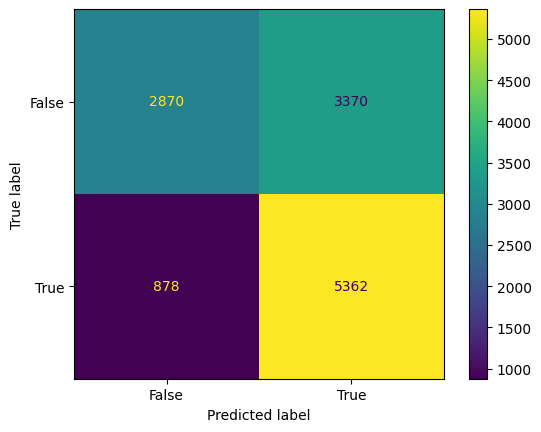

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(labels, np.argmax(predictions, axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(labels, np.argmax(predictions, axis=1))
recall = recall_score(labels, np.argmax(predictions, axis=1))
accuracy = accuracy_score(labels, np.argmax(predictions, axis=1))
f1 = f1_score(labels, np.argmax(predictions, axis=1))

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1-score:", f1)

Precision: 0.614063215758131
Recall: 0.8592948717948717
Accuracy: 0.6596153846153846
F1-score: 0.7162703713598718
